<a href="https://colab.research.google.com/github/danielquillanroxas/Background-Removal/blob/main/BackgroundRemovalWebApp_Backend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# install requirements
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install torch torchvision opencv-python numpy

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-7b7thca1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-7b7thca1
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [4]:
# create sam predictor
from segment_anything import SamPredictor, sam_model_registry
import os

model_path = './sam_vit_b_01ec64.pth'

if not os.path.exists(model_path):
  !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

sam = sam_model_registry["vit_b"](checkpoint= model_path)
predictor = SamPredictor(sam)

In [5]:
# load image and select x, y coordinates to test
import cv2

image_path = './test.jpg'
if not os.path.exists(image_path):
  !wget https://utils-computervisiondeveloper.s3.amazonaws.com/media/public/test.jpg

x = 528
y = 606

image = cv2.imread(image_path)

In [6]:
# use sam predictor on (image, x, y) to get the location of the subject
import numpy as np
predictor.set_image(image)

masks, scores, logits = predictor.predict(
                              point_coords = np.asarray([[x,y]]),
                              point_labels = np.asarray([1]),
                              multimask_output = True
                          )

C, H, W = masks.shape

result_mask = np.zeros((H, W), dtype = bool)

for j in range(C):
  result_mask |= masks[j, :, : ]

result_mask = result_mask.astype(np.uint8)



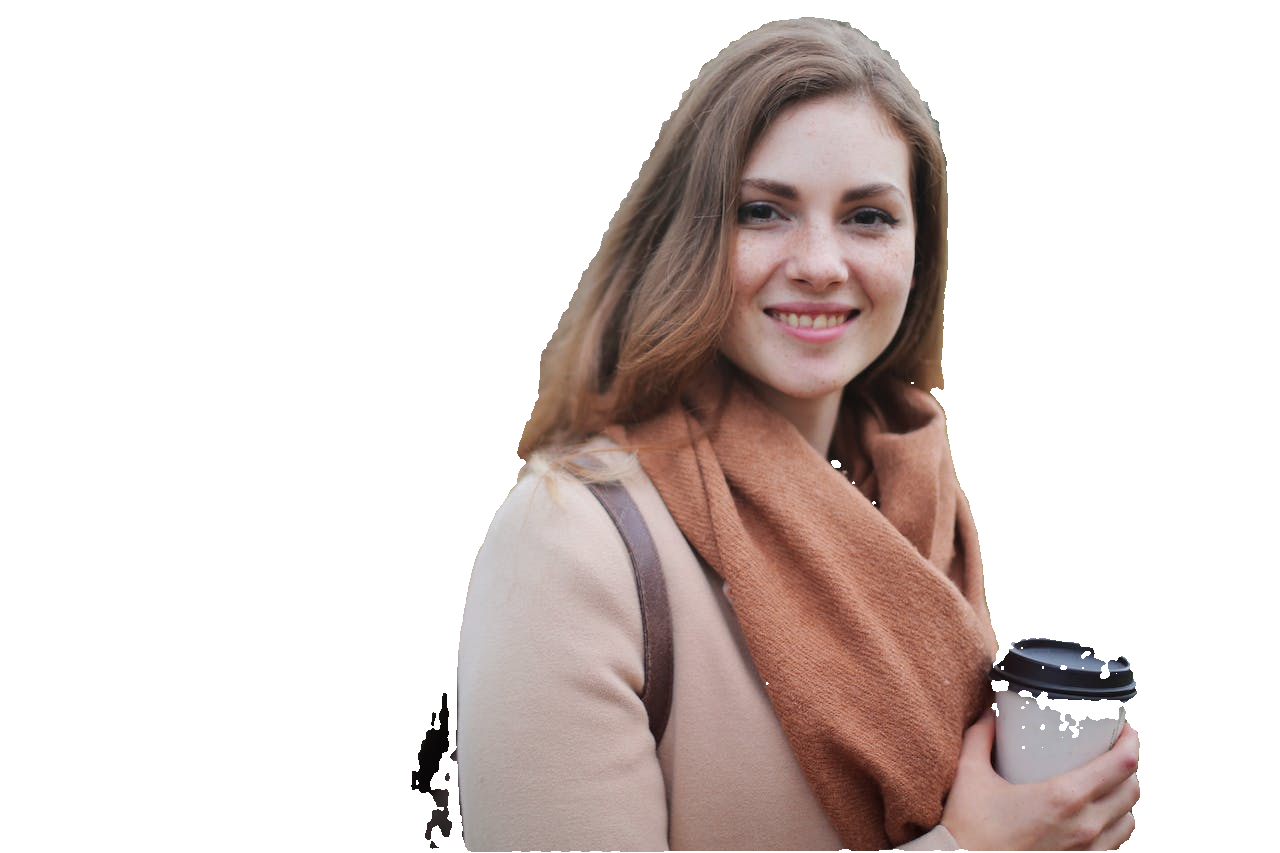

In [7]:
# remove background
from google.colab.patches import cv2_imshow

alpha_channel = np.ones(result_mask.shape, dtype = result_mask.dtype) * 255

alpha_channel[result_mask == 0] = 0

result_image = cv2.merge((image, alpha_channel))

cv2_imshow(result_image)

In [15]:
# wrap it up as a function
import base64
import os

from segment_anything import SamPredictor, sam_model_registry
import cv2
import numpy as np

model_path = './sam_vit_b_01ec64.pth'

if not os.path.exists(model_path):
  !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

sam = sam_model_registry["vit_b"](checkpoint= model_path)
predictor = SamPredictor(sam)

def remove_background(image_base64_encoding, x, y):

  image_bytes = base64.b64decode(image_base64_encoding)

  image = cv2.imdecode(np.frombuffer(image_bytes, dtype=np.uint8), cv2.IMREAD_COLOR)

  predictor.set_image(image)

  masks, scores, logits = predictor.predict(
                                point_coords = np.asarray([[x,y]]),
                                point_labels = np.asarray([1]),
                                multimask_output = True
                            )

  C, H, W = masks.shape

  result_mask = np.zeros((H, W), dtype = bool)

  for j in range(C):
    result_mask |= masks[j, :, : ]

  result_mask = result_mask.astype(np.uint8)

  alpha_channel = np.ones(result_mask.shape, dtype = result_mask.dtype) * 255

  alpha_channel[result_mask == 0] = 0

  result_image = cv2.merge((image, alpha_channel))

  _, result_image_bytes = cv2.imencode('.png', result_image)

  result_image_bytes = result_image_bytes.tobytes()

  result_image_bytes_encoded_base64 = base64.b64encode(result_image_bytes).decode('utf-8')

  return result_image_bytes_encoded_base64

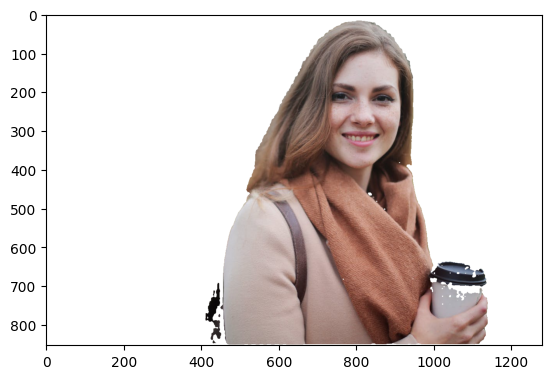

In [9]:

import cv2
import matplotlib.pyplot as plt


image_path = './test.jpg'
if not os.path.exists(image_path):
  !wget https://utils-computervisiondeveloper.s3.amazonaws.com/media/public/test.jpg

x = 528
y = 606

image = cv2.imread(image_path)

_, image_bytes = cv2.imencode('.png', image)

image_bytes = image_bytes.tobytes()

image_bytes_encoded_base64 = base64.b64encode(image_bytes).decode('utf-8')

result_image = remove_background(image_bytes_encoded_base64, x, y)

result_image_bytes = base64.b64decode(result_image)

result_image = cv2.imdecode(np.frombuffer(result_image_bytes, dtype=np.uint8), cv2.IMREAD_UNCHANGED)

plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGRA2RGBA))
plt.show()

In [10]:
!pip install modelbit

In [11]:
import modelbit
mb = modelbit.login()

In [16]:
mb.deploy(remove_background)

Encrypting 'predictor': 387MB [00:02, 163MB/s]                           
Uploading 'predictor': 100%|██████████| 348M/348M [00:11<00:00, 30.9MB/s]


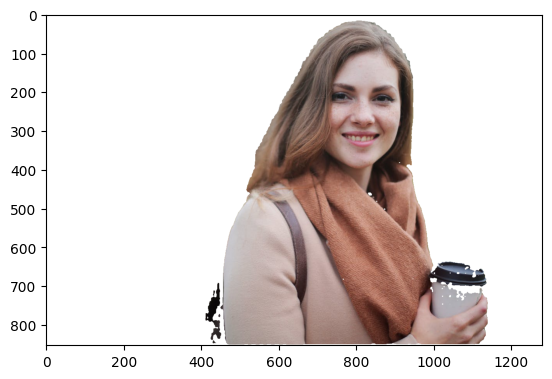

In [17]:
import cv2
import matplotlib.pyplot as plt
import requests


api_endpoint = 'https://danielquillanroxas.us-east-1.modelbit.com/v1/remove_background/latest'


image_path = './test.jpg'
if not os.path.exists(image_path):
  !wget https://utils-computervisiondeveloper.s3.amazonaws.com/media/public/test.jpg

x = 528
y = 606

image = cv2.imread(image_path)

_, image_bytes = cv2.imencode('.png', image)

image_bytes = image_bytes.tobytes()

image_bytes_encoded_base64 = base64.b64encode(image_bytes).decode('utf-8')

api_data = {"data": [image_bytes_encoded_base64, x, y]}
response = requests.post(api_endpoint, json = api_data)

result_image = response.json()['data']

result_image_bytes = base64.b64decode(result_image)

result_image = cv2.imdecode(np.frombuffer(result_image_bytes, dtype=np.uint8), cv2.IMREAD_UNCHANGED)

plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGRA2RGBA))
plt.show()